## 00 . Import packages

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as prof

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

/software/intel/2017.0516/intelpython27/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## 01 . Import data

In [3]:
data = pd.read_csv('../data/samsungData.txt',sep='|')

## 02 . Create train & test set

In [4]:
randomState = 42
ntree = 25

In [5]:
train = data.sample(frac=0.7,
                    random_state=randomState)

test = data[~data.index.isin(train.index)]

## 03.a. Base RF - with all variables

In [6]:
def varPlot(X,model,plotSize=(15,6),xticks=False):
    
    model_vars = pd.DataFrame(
         {'variable':X.columns,
          'importance':model.feature_importances_})

    model_vars.sort_values(by='importance',
                           ascending=False,
                           inplace=True)
    
    varImp = sns.plt.figure(figsize=plotSize)
    varImp = sns.set_style('whitegrid')

    varImp = sns.barplot(y='importance',
        x='variable',
        data=model_vars,
        palette=sns.color_palette("Blues_r",
                                  n_colors=X.shape[1]))
    
    if xticks==True:
        varImp = sns.plt.xticks([])
    else:
        varImp = sns.plt.xticks(rotation=90)
        
    varImp = sns.plt.xlabel('Variable')
    varImp = sns.plt.ylabel('Variable Importance')
    varImp = sns.plt.title('Random Forest : Averaged variable importance over '+str(ntree)+' trees')
    return(varImp)

#### Build model containing all 561 variables

In [7]:
X = train[train.columns[:-2]]
Y = train.activity
randomState = 42

model0 = rfc(n_estimators=ntree,
             random_state=randomState,
             n_jobs=4,
             warm_start=True,
             oob_score=True)
model0 = model0.fit(X, Y)
model0.oob_score_

0.96502137582588421

#### Variable importance : all 561 variables

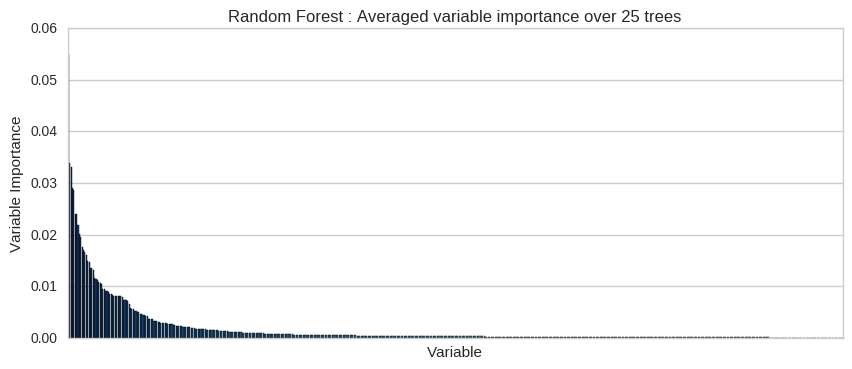

In [8]:
varPlot(X=X,model=model0,plotSize=(10,4),xticks=True)

#### Sorted dataframe for variable & their importance score

In [9]:
model_vars0 = pd.DataFrame(
         {'variable':X.columns,
          'importance':model0.feature_importances_})

model_vars0.sort_values(by='importance',
                           ascending=False,
                           inplace=True)

## 03.b. top n variables

In [10]:
n = 25

cols_model = [col for col in model_vars0.variable[:n].values]

#### Create OOB accuracy table for using top 1 to n variables at a time

In [11]:
oobAccuracy = {}

for cols in range(n):
    X = train[[col for col in model_vars0['variable'][:cols+1].values]]
    Y = train.activity
    
    model1 = rfc(n_estimators=ntree,
                 random_state=randomState,
                 n_jobs=4,
                 warm_start=False,
                 oob_score=True)
    
    model1 = model1.fit(X, Y)
    accuracy = accuracy_score(Y,model1.predict(X))
    
    oobAccuracy[cols+1] = [cols+1,model1.oob_score_,accuracy]

accuracyTable =pd.DataFrame.from_dict(oobAccuracy).transpose()
accuracyTable.columns = ['variables','oobAccuracy','accuracy']

#### Plot OOB accuracy vs number of variables

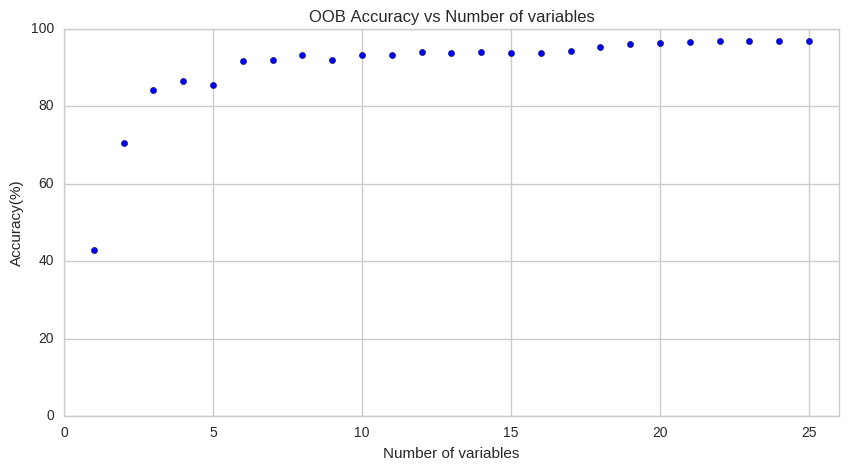

In [12]:
sns.plt.figure(figsize=(10,5))
sns.plt.scatter(x=accuracyTable.variables,
                y=100*accuracyTable.oobAccuracy)

sns.plt.xlim(0,n+1)
sns.plt.ylim(0,100)
sns.plt.minorticks_on()

sns.plt.xlabel('Number of variables')
sns.plt.ylabel('Accuracy(%)')
sns.plt.title('OOB Accuracy vs Number of variables')

#### Variable importance plot for top n variables

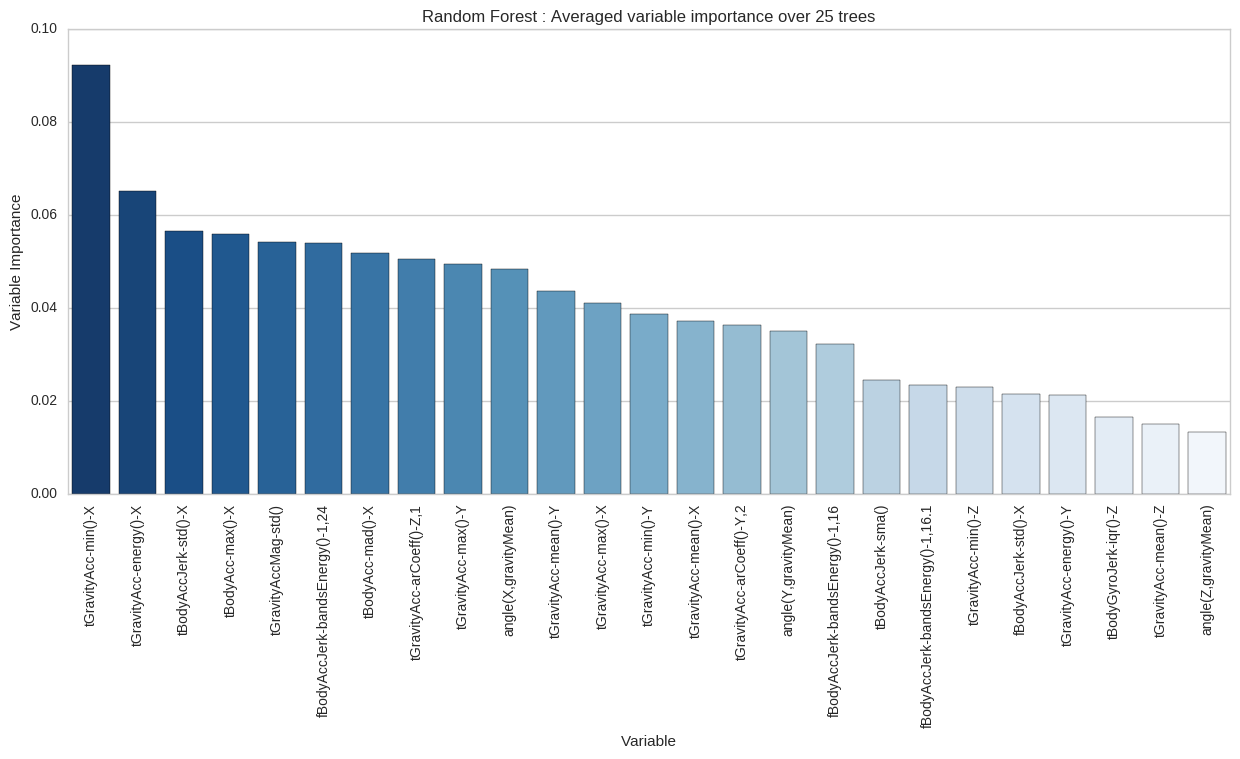

In [13]:
varPlot(X,model1)

## 03.c. Selected variables (5) from top 15

In [14]:
n_used = 4

cols_model = [col for col in model_vars0.variable[:n_used].values] + [model_vars0.variable[6]]

In [15]:
X = train[cols_model]
Y = train.activity

#### For the selected variables, we determine optimum number of trees

 - Create a loop for 5 to 150 trees with steps of 5
 
 - Fit a model during each iteration
 
 - Store OOB score for each iteration

In [16]:
ntree_determination = {}

for ntree in range(5,150,5):
    model = rfc(n_estimators=ntree,
             random_state=randomState,
             n_jobs=4,
             warm_start=False,
             oob_score=True)
    model = model.fit(X, Y)
    ntree_determination[ntree]=model.oob_score_

/software/intel/2017.0516/intelpython27/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/software/intel/2017.0516/intelpython27/lib/python2.7/site-packages/sklearn/ensemble/forest.py:408: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [17]:
ntree_determination = pd.DataFrame.from_dict(ntree_determination,orient='index')
ntree_determination['ntree'] = ntree_determination.index
ntree_determination.columns=['oobScore','ntree']

#### Plot number of trees vs OOB accuracy

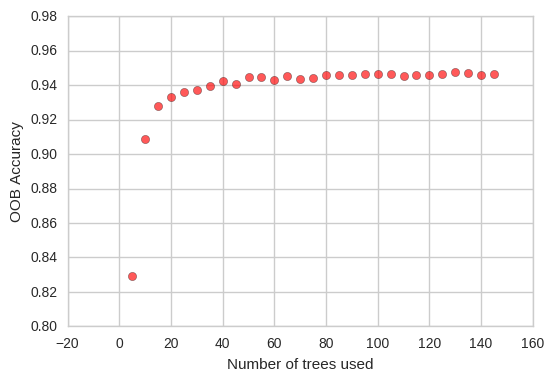

In [18]:
sns.plt.figure(figsize=(6,4),)

sns.plt.scatter(x='ntree',
                y='oobScore',
                s=35,c='red',alpha=0.65,
                data=ntree_determination)
sns.plt.xlabel('Number of trees used')
sns.plt.ylabel('OOB Accuracy')

#### For our final iteration, we choose 50 trees & 5 variables

In [19]:
model2 = rfc(n_estimators=50,
             random_state=randomState,
             n_jobs=4,
             warm_start=False,
             oob_score=True)
model2 = model2.fit(X, Y)

#### Variable importance plot for the final model

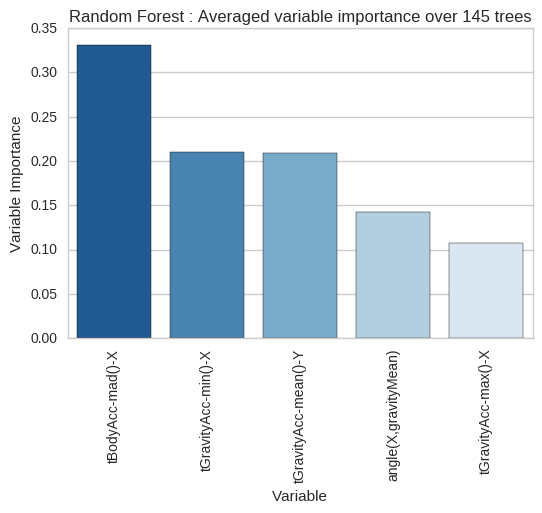

In [20]:
varPlot(X,model2,plotSize=(6,4))

### Accuracy metrics for the final model

In [21]:
train_actual = Y
train_pred = model2.predict(X)

#### Confusion matrix for training data

In [29]:
confusion_matrix(train_actual,train_pred)

array([[984,   0,   0,   0,   0,   0],
       [  0, 904,   0,   0,   0,   0],
       [  0,   0, 966,   0,   0,   0],
       [  0,   0,   0, 847,   0,   0],
       [  0,   0,   0,   0, 708,   0],
       [  0,   0,   0,   0,   0, 737]])

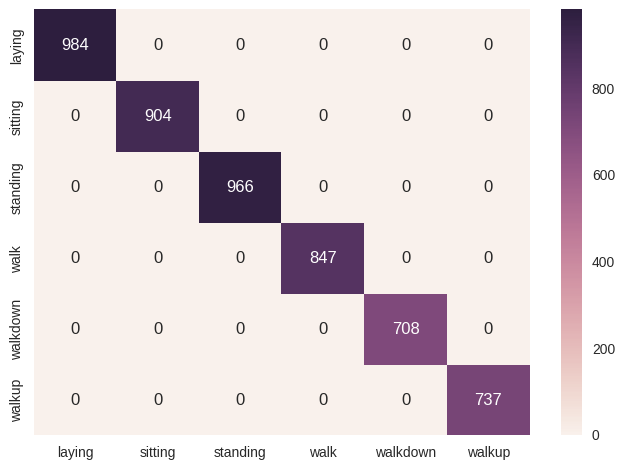

In [31]:
sns.heatmap(data=confusion_matrix(train_actual,train_pred),
            fmt='.0f',
            annot=True,
            xticklabels=np.unique(train_actual),
            yticklabels=np.unique(train_actual))

#### Training accuracy

In [23]:
accuracy_score(train_actual,train_pred)

1.0

#### OOB accuracy

In [24]:
model2.oob_score_

0.94500582977069569

## 4. Test set results

In [25]:
test_actual = test.activity
test_pred = model2.predict(test[X.columns])

#### Confusion matrix for test data

In [26]:
confusion_matrix(test_actual,test_pred)

array([[423,   0,   0,   0,   0,   0],
       [  0, 365,  17,   0,   0,   0],
       [  0,  21, 387,   0,   0,   0],
       [  0,   0,   0, 351,  17,  11],
       [  0,   0,   0,  14, 246,  18],
       [  0,   0,   0,  14,  12, 310]])

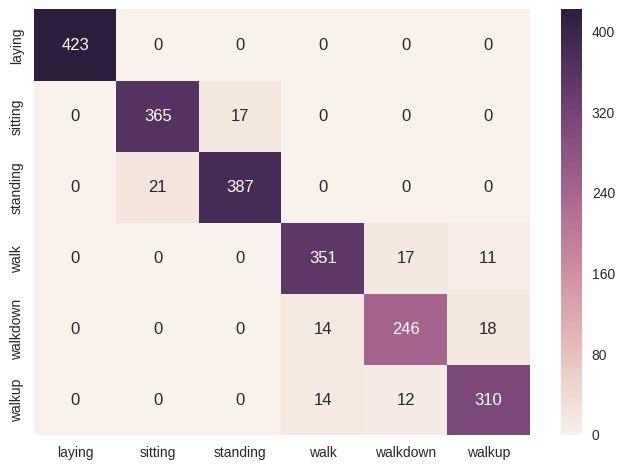

In [33]:
sns.heatmap(data=confusion_matrix(test_actual,test_pred),
            fmt='.0f',
            annot=True,
            xticklabels=np.unique(test_actual),
            yticklabels=np.unique(test_actual))

#### Accuracy on test data

In [27]:
accuracy_score(test_actual,test_pred)

0.94378966455122393

#### Distribution of final variables for each category

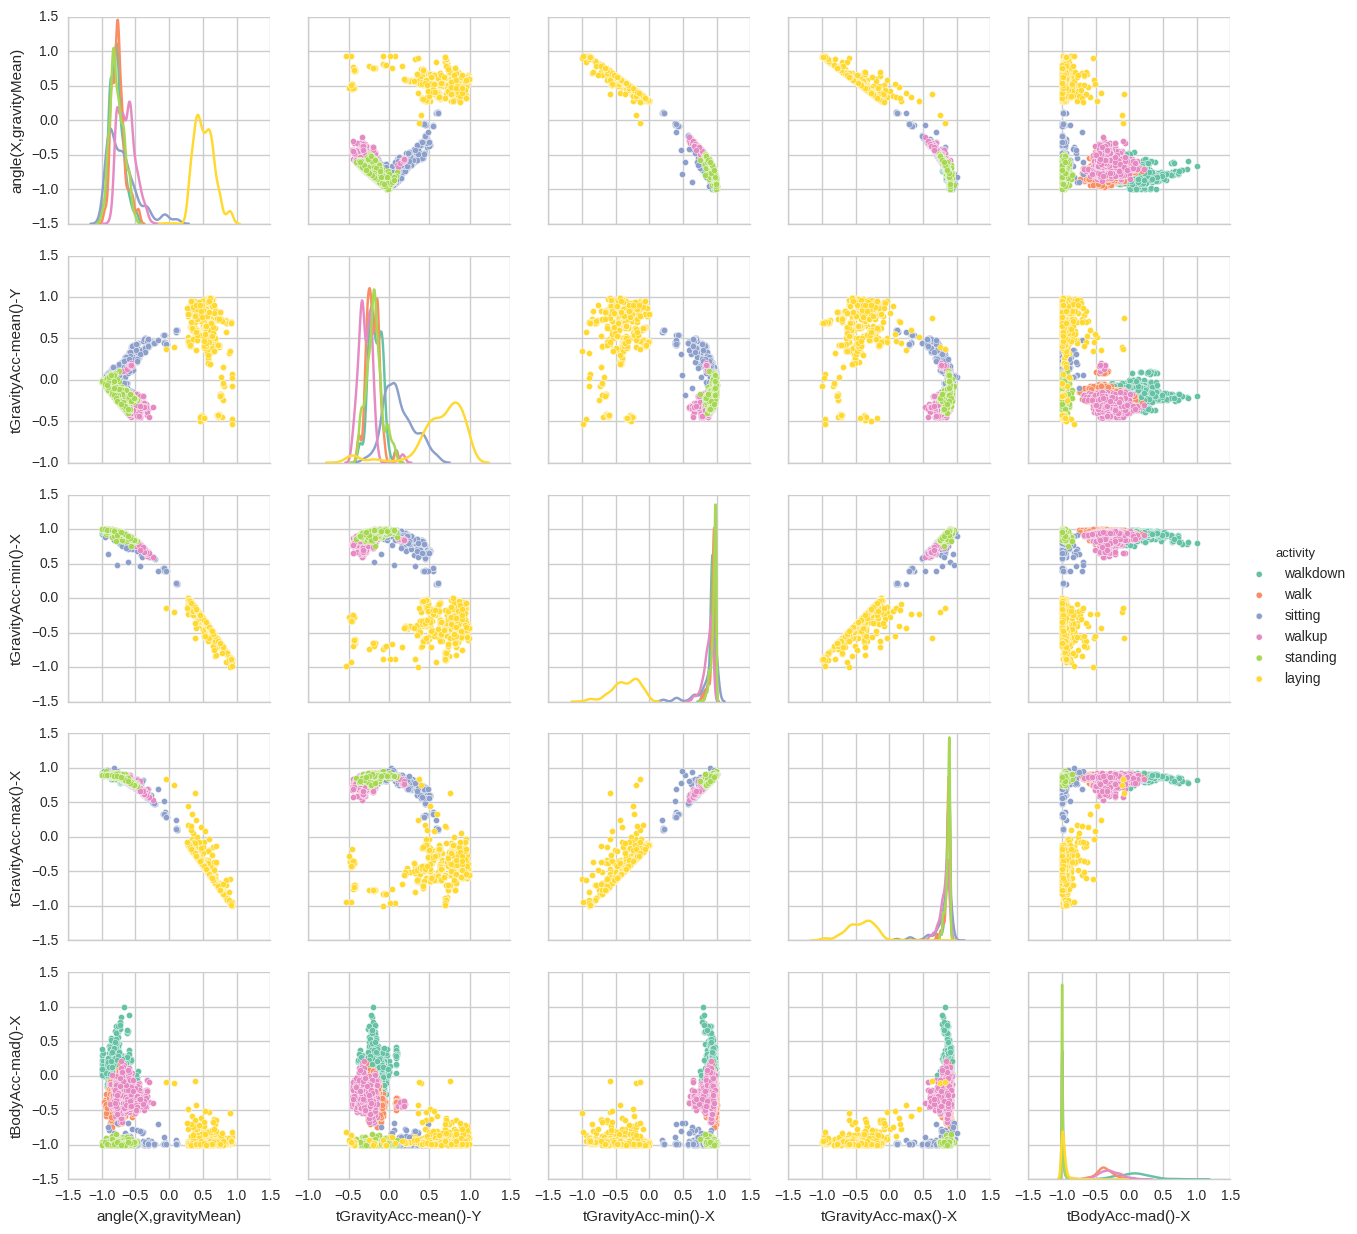

In [28]:
sns.plt.figure(figsize=(6,6))
sns.set_style('whitegrid')

sns.pairplot(data=train[[col for col in X.columns]+['activity']],
             hue='activity',
             palette='Set2',
             diag_kind='kde')